# Binary-Class Image Classification Model for Pizza vs. Ice Cream Using TensorFlow Take 1
### David Lowe
### February 13, 2023

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Pizza vs. Ice Cream dataset is a binary classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: The dataset contains over 1,000 images of pizza and ice cream. The researcher collected these images to investigate the machine learning model's ability to understand and distinguish the basic features of pizza and ice cream.

ANALYSIS: The Xception model's performance achieved an accuracy score of 99.04% after five epochs using the validation dataset. When we applied the model to the test dataset, the model achieved an accuracy score of 98.11%.

CONCLUSION: In this iteration, the TensorFlow Xception CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Binary classification with numerical features

Dataset Used: Pizza vs. Ice Cream

Dataset Reference: https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream

One source of potential performance benchmarks: https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream/code

# Task 1 - Prepare Environment

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sat Feb 11 17:45:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 5
BATCH_SIZE = 16
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (299, 299)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/dataset/train'
VALID_DIR = 'staging/dataset/valid'
TEST_DIR = 'staging/dataset/test'
TRAIN_DATASET = 'archive.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.11.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [10]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-hemendrasr-pizza-ice-cream/archive.zip

zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

--2023-02-11 17:45:16--  https://dainesanalytics.com/datasets/kaggle-hemendrasr-pizza-ice-cream/archive.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.52.82, 13.226.52.21, 13.226.52.95, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.52.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43711323 (42M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  41.69M  35.4MB/s    in 1.2s    

2023-02-11 17:45:17 (35.4 MB/s) - ‘archive.zip’ saved [43711323/43711323]



In [12]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)
NUM_CLASSES = len(CLASS_LABELS)
print('Total number of classes detected:', NUM_CLASSES)
if CLASSIFIER_ACTIVATION == 'sigmoid':
    NUM_CLASSES = 1

['pizza', 'icecream']
Total number of classes detected: 2


In [13]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    train_class_dir = os.path.join(TRAIN_DIR, c_label)
    train_class_files = os.listdir(train_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(train_class_dir)))
    print('Training samples for', c_label, ':', train_class_files[:5],'\n')

Number of training images for pizza : 327
Training samples for pizza : ['00389_jpg.rf.6fc545ab167b4802df4c4bd1f6f4f7a1.jpg', '00201_jpg.rf.176daff630e51aff95dbf93c8c67db28.jpg', '00284_jpg.rf.55ea86cc737e7b6e1dae0b6d1846ea53.jpg', '000_jpg.rf.165ea55c86e1d30dd27b31a123b53362.jpg', '00513_jpg.rf.6a5c6d610204b907304074c791c0d274.jpg'] 

Number of training images for icecream : 391
Training samples for icecream : ['00404_jpg.rf.09faff222d84974f48de0e063367af7f.jpg', '0046_jpg.rf.b8b40745148cf26c2f68f35714696a88.jpg', '00197_jpg.rf.be5dcc1fb36d6bffe198517ceaf80643.jpg', '0050_jpg.rf.fdf91b737cc75386f5175df7be8a6553.jpg', '00594_jpg.rf.0b29de89560a0c71913caa1b79437dab.jpg'] 



In [14]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    valid_class_dir = os.path.join(VALID_DIR, c_label)
    valid_class_files = os.listdir(valid_class_dir)
    print('Number of validation images for', c_label, ':', len(os.listdir(valid_class_dir)))
    print('Validation samples for', c_label, ':', valid_class_files[:5],'\n')

Number of validation images for pizza : 94
Validation samples for pizza : ['00450_jpg.rf.54031ab6bfffb1c144426fb10e559f31.jpg', '00227_jpg.rf.2f31f00d052e06ac615c780e89c2914b.jpg', '00480_jpg.rf.fcc01c2f4f00039dc3363f7dfa176af5.jpg', '00234_jpg.rf.d3be9bec1ee9a1813bf4d256d07b451c.jpg', '00354_jpg.rf.b52bdcebc58b8b24ff13f688881698b5.jpg'] 

Number of validation images for icecream : 114
Validation samples for icecream : ['00415_jpg.rf.598f9132f3c0781070c1507b8d167282.jpg', '0042_jpg.rf.e976762e3ff32cc04c582684f78ee32a.jpg', '00620_jpg.rf.83e41c5a8e325f22db32f2d0a8656f2e.jpg', '00508_jpg.rf.7fe9dfcc7dc4938f67a2b062e3d83cc2.jpg', '009_jpg.rf.ee693400fb6f4c4f64550fe8e5169066.jpg'] 



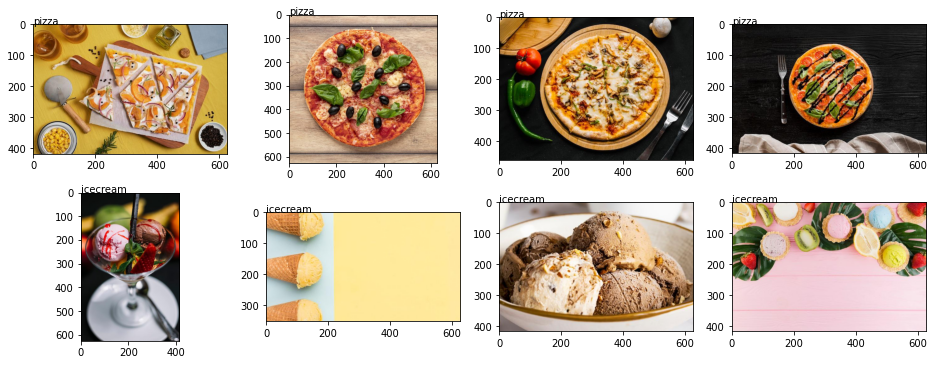

In [15]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [16]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 718 images belonging to 2 classes.
Number of training image batches per epoch of modeling: 45
Loading and pre-processing the validation images...
Found 208 images belonging to 2 classes.
Number of validation image batches per epoch of modeling: 13


In [17]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [18]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [19]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [20]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [21]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=2)
print('Total time for model fitting:', (datetime.now() - start_time_module))

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/5
45/45 - 43s - loss: 1.1542 - accuracy: 0.8677 - val_loss: 0.0380 - val_accuracy: 0.9808 - 43s/epoch - 966ms/step
Epoch 2/5
45/45 - 5s - loss: 0.0661 - accuracy: 0.9791 - val_loss: 0.0285 - val_accuracy: 0.9904 - 5s/epoch - 108ms/step
Epoch 3/5
45/45 - 5s - loss: 0.0105 - accuracy: 0.9958 - val_loss: 0.0940 - val_accuracy: 0.9712 - 5s/epoch - 109ms/step
Epoch 4/5
45/45 - 5s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9904 - 5s/epoch - 107ms/step
Epoch 5/5
45/45 - 5s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9904 - 5s/epoch - 107ms/step
Total time for model fitting: 0:01:06.138792


In [22]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 2048)              419432448 
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 440,295,977
Trainable params: 440,241,449
Non-trainable params: 54,528
_________________________________________________________________


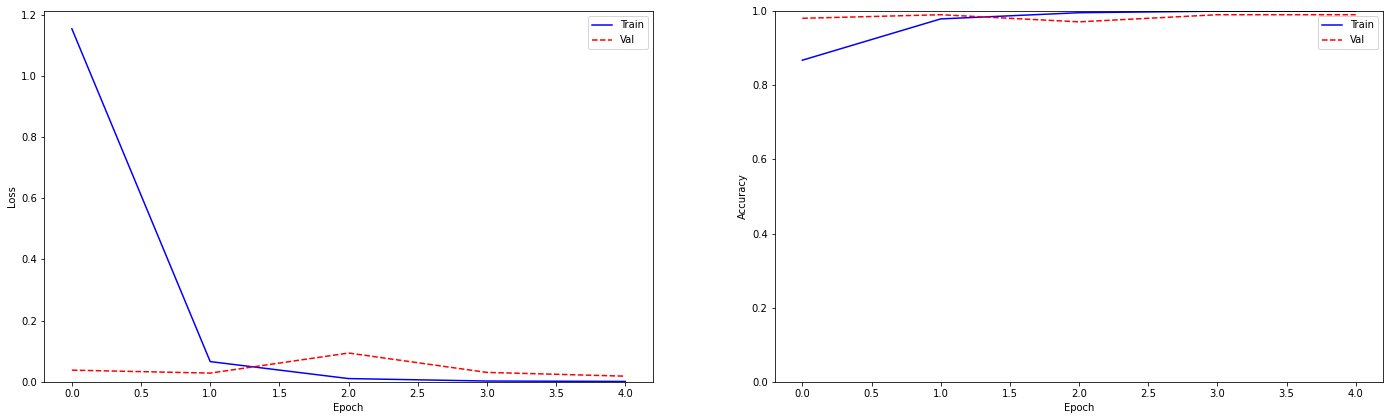

In [23]:
plot_metrics(baseline_model_history)

In [24]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [25]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [26]:
# Not applicable for this iteration of modeling

In [27]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [28]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 5.a) Train the Final Model

In [29]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
FINAL_EPOCHS = MAX_EPOCHS
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=FINAL_EPOCHS, verbose=2)
final_model.summary()

Epoch 1/5
45/45 - 27s - loss: 0.8131 - accuracy: 0.9039 - 27s/epoch - 608ms/step
Epoch 2/5
45/45 - 4s - loss: 0.0756 - accuracy: 0.9861 - 4s/epoch - 84ms/step
Epoch 3/5
45/45 - 4s - loss: 0.0111 - accuracy: 0.9958 - 4s/epoch - 86ms/step
Epoch 4/5
45/45 - 4s - loss: 0.0087 - accuracy: 0.9958 - 4s/epoch - 82ms/step
Epoch 5/5
45/45 - 4s - loss: 0.0330 - accuracy: 0.9972 - 4s/epoch - 84ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 2048)              419432448 
                                                                 
 dense_3 (Dense)             (None, 1)                 20

## 5.b) Load Test Dataset and Make Predictions

In [30]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(TEST_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for pizza : 47
Training samples for pizza :
['00178_jpg.rf.380d5d3870f6b83b99f2e49185501afb.jpg', '00349_jpg.rf.def71adac7a0795ec550d2ec65c13df8.jpg', '00269_jpg.rf.892c40e5f5f835c122763e6ec7735964.jpg', '00413_jpg.rf.65bc71a6608af35489f10bb7ee9ce2c2.jpg', '00434_jpg.rf.0a6dee4b4877843c4102f57213200978.jpg'] 

Number of test images for icecream : 59
Training samples for icecream :
['00602_jpg.rf.fbec086a30d9d5ad29267be611335285.jpg', '00328_jpg.rf.e0196b6566f22462e198a029969ed755.jpg', '00368_jpg.rf.0452fa0b25177e9be94789a88e8763bb.jpg', '00453_jpg.rf.76ef92a99877324c1f669e25f27f72a5.jpg', '00489_jpg.rf.8aa48832fb9e8c5d3aae4e1ad46918fd.jpg'] 



In [31]:
datagen_kwargs = dict(rescale=1./255)
test_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

print('Loading and pre-processing the test images...')
test_generator = validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of test image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 106 images belonging to 2 classes.
Number of test image batches per epoch of modeling: 7


In [32]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'icecream': 0, 'pizza': 1}


In [33]:
test_pred = final_model.predict(test_generator)
test_predictions = (test_pred > 0.5).astype('int').ravel()
test_original = test_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

7/7 [==============================] - 2s 123ms/step
Accuracy Score: 0.9811320754716981
[[59  0]
 [ 2 45]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       1.00      0.96      0.98        47

    accuracy                           0.98       106
   macro avg       0.98      0.98      0.98       106
weighted avg       0.98      0.98      0.98       106



In [34]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:02:00.563171
